#### Johannes Preprocessing: https://github.com/jfilter/tmip/blob/master/preprocess_pol.ipynb

In [1]:
import datetime
import os
import re
import urllib
import sys
import math
import numpy as np
import pandas as pd
from scipy.stats import describe
from gensim.models.wrappers import FastText

from matplotlib import pyplot as plt

# Data files

# article_id, article_url
SRC_ARTICLES = '../data/guardian-all/articles-standardized.csv'
SRC_AUTHORS = '../data/guardian-all/authors-standardized.csv'
SRC_COMMENTS = '../data/guardian-all/sorted_comments-standardized.csv'
SRC_COMMENTS_POL = '../data/pol/comments-root-all-pol.csv'
SRC_COMMENTS_POL_WITH_REPLIES = '../data/pol/comments-all-pol.csv'
# SRC_COMMENTS_POL_TEXT = '../data/guardian-all/sorted_comments-standardized-pol-text.csv'
SRC_COMMENTS_TOKENIZED_ORIG_BIN = "../data/embedding/guardian-comments-50-tokenized.bin"
SRC_COMMENTS_TOKENIZED_BIN_GENSIM = "../data/embedding/gensim-guardian-comments-50-tokenized.bin"

def save_embedding(word_vectors):
    print("saving embeddings...")
    # word_vectors = KeyedVectors.load_word2vec_format('wordvectors.w2v')
    word_vectors.save(SRC_COMMENTS_TOKENIZED_BIN_GENSIM)
    # word_vectors.save_word2vec_format('wordvectors.w2v')

c:\users\thomas\hpi\textmi~1\venv\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [ ]:
% load_ext autoreload
% autoreload 2
import data_utils
import viz_utils
import text_utils

In [ ]:
model = FastText.load_fasttext_format(SRC_COMMENTS_TOKENIZED_ORIG_BIN)
# Weight matrix: model.wv.syn0
# Word vectors: model.wv.vocab

In [71]:
save_embedding(model)

saving embeddings...


In [2]:
data_articles = pd.read_csv(SRC_ARTICLES)  # shape = (626395, 2)
# data_articles_pol = data_articles[data_articles['article_url'].str.contains('/politics/')]  # shape = (20167, 2)

### Selecting only politic articles

In [3]:
data_articles_pol = data_articles[data_articles['article_url'].str.contains('/politics/')]  # shape = (20167, 2)

Shape of data_articles_pol: (20167, 2)


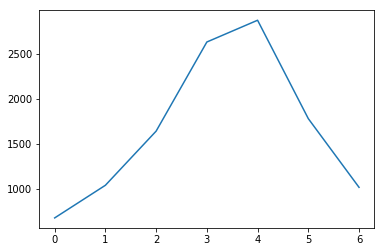

In [6]:
def get_articles(year):
    return data_articles[data_articles['article_url'].str.contains('/politics/{}'.format(year))]

plt.plot([get_articles(x).shape[0] for x in range(2011, 2018)])

# Let's use 2015 (most politics articles)
# data_articles_pol = get_articles(2015)
data_articles_pol = data_articles[data_articles['article_url'].str.contains('.com/politics/')]
print('Shape of data_articles_pol: {}'.format(data_articles_pol.shape))

In [7]:
article_ids = set(data_articles_pol['article_id'])
data_comments_pol = []  # Only parent comments
data_comments_pol_all = []  # Includes replies
headline = pd.read_csv(SRC_COMMENTS, nrows=10)
for df_chunk in pd.read_csv(SRC_COMMENTS, header=None, skiprows=0, chunksize=1000000):
    print('.', end='')
    matches = df_chunk[df_chunk[0].isin(article_ids)]
    if len(matches):
        print(len(matches), end='')
        data_comments_pol_all.append(matches)
        
        # Remove replies
        matches = matches[matches[5].isnull()]  # index 5 is 'parent_comment_id'
        if len(matches):
            print('({})'.format(len(matches)), end='')
            data_comments_pol.append(matches)
            
data_comments_pol = pd.concat(data_comments_pol)
data_comments_pol.columns = headline.columns  # shape = (40974, 7)
columns = list(headline.columns)
columns.remove('parent_comment_id')
data_comments_pol = data_comments_pol[columns]  # shape = (40974, 6)
data_comments_pol.to_csv(SRC_COMMENTS_POL)

data_comments_pol_all = pd.concat(data_comments_pol_all)
data_comments_pol_all.columns = headline.columns  # shape = (?, 7)
data_comments_pol_all.to_csv(SRC_COMMENTS_POL_WITH_REPLIES)

c:\users\thomas\hpi\textmi~1\venv\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,1,2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


.43582(19060).289678(113772).64050(37100).1760(603).85757(24764).161535(70331).20331(6391).23705(9516).2783(1099).24824(10720).973(756).5524(2336).8676(5277).18067(9057).19962(9630).264810(94433).54250(37171).2196(1161).171445(53425).48768(31827).20367(8061).5844(1907).18107(9277).3194(1472).11458(5326).14609(6440).172106(54507).91423(56521).7155(2429).172137(68028).22146(7238).7864(4032).14404(6180).8211(4123).9886(4661).239436(97415).17546(8600).152998(58245).15338(5043).12913(5972).7690(3641).13280(6023).184438(76216).62535(17593).66522(32233).8953(4420).5483(2657).12709(4753).4484(2240).7720(3847).122450(48414).86470(32974).9874(4306).6662(3296).136859(51135).55406(24918).4041(1432).74869(31223).39330(14815).55489(23522).56432(24185).5089(2838)

### Selecting other categories

(-1.1446754838144815,
 2.0105530598715635,
 -1.1008885232858763,
 1.1000423106327344)

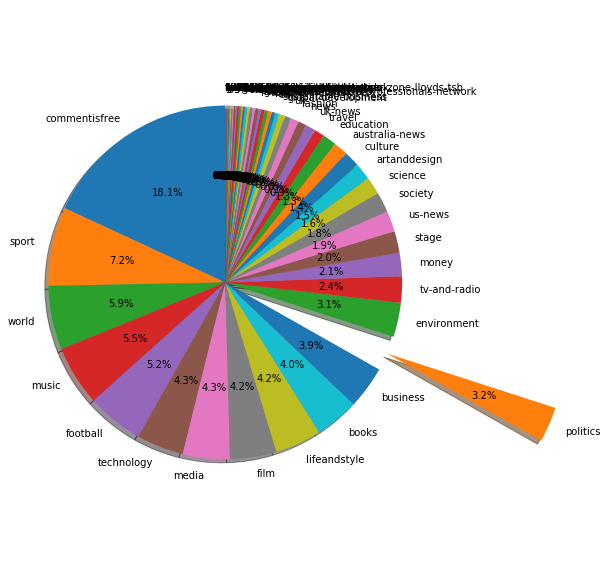

In [142]:
# np.set_printoptions(threshold=np.inf)
regex = re.compile('https://www\.theguardian\.com/([^/]*)(/(.*)|$)')
sections = [regex.match(x).group(1) for x in data_articles['article_url'] if regex.match(x)]
mismatches = [x for x in data_articles['article_url'].unique() if not regex.match(x)]
print(f'Not matching URLs: {"  ".join(mismatches)}')

section_counts = pd.DataFrame(sections).groupby(0).apply(lambda x: len(x))
section_counts = list(zip(section_counts.index, section_counts.values))
section_counts = np.array(sorted(section_counts, reverse=True, key=lambda x: x[1]))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.pie(section_counts[:, 1], labels=section_counts[:, 0], autopct='%1.1f%%',
       explode=[x == 'politics' for x in section_counts[:, 0]],shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.